 # Image Captioning 

 
   # What is Image Captioning?
   Image Captioning is the process of generating textual description of an image. It uses         both Natural Language Processing and Computer Vision to generate the captions.

![](https://i.imgur.com/tVtHhNp.png)

# Image Encoder, Text Decoder
Since we have a separate encoder and decoder, we could also have an encoder that encodes images, and a decoder that decodes text, giving us an image captioning model.

![](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)

# Import Modules

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


C:\Users\RAGHAV\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Import Data_DIR , Work_DIR

In [2]:
import os

# Define the base directory for the Flickr8k dataset
BASE_DIR = r"C:\Users\RAGHAV\Documents\minor project\mulla\flickr8k"

# Define the working directory
WORKING_DIR = os.getcwd()  # Gets the current working directory where the script is located


# Extract Image Features

In [3]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [4]:
model2 = ResNet50(weights="imagenet", input_shape=(224,224,3))

102967424/102967424 [==============================] - 9s 0us/step


In [5]:
model2.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [6]:
#removing last layer from resnet
model_resnet = Model(model2.input, model2.layers[-2].output)

# extract features from image

In [4]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name1 in tqdm(os.listdir(directory)):
    # load the image from file
    img_path1 = directory + '/' + img_name1
    image1 = load_img(img_path1, target_size=(224, 224))
    # convert image pixels to numpy array
    image1 = img_to_array(image1)
    # reshape data for model
    image1 = image1.reshape((1, image1.shape[0], image1.shape[1], image1.shape[2]))
    # preprocess image for vgg
    image1 = preprocess_input(image1)
    # extract features
    feature = model.predict(image1, verbose=0)
    # get image ID
    image_id1 = img_name1.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8092 [00:00<?, ?it/s]

In [7]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model_resnet.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

# store features in pickle

In [5]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [6]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

# Load the Captions Data

In [7]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
len(mapping)

8091

# Preprocess Text Data

In [10]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [11]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:
# preprocess the text
clean(mapping)

In [13]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
len(all_captions)

40455

In [16]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [17]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
vocab_size

8485

In [19]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

# Train Test Split

In [20]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [21]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [22]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

# Model Creation

In [23]:
import pydot
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
#plot_model(model, show_shapes=True)

In [24]:
# train the model
epochs = 15
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


227/227 [==============================] - 830s 4s/step - loss: 2.3567


In [25]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

C:\Users\RAGHAV\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Generate Captions for the Image

In [26]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [27]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [28]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.537850
BLEU-2: 0.315181


In [29]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs playing with each other in the grass endseq


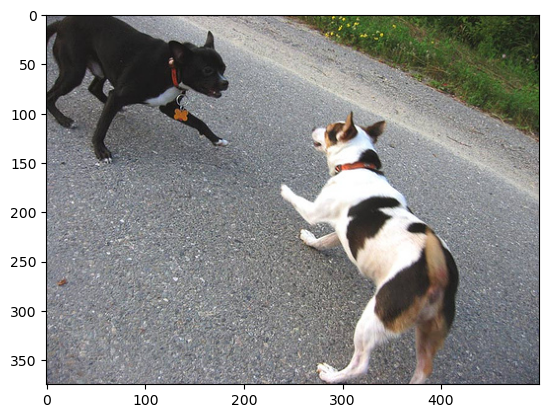

In [30]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq group of eight people are gathered around table at night endseq
startseq group of people gathered around in the dark endseq
startseq group of people sit around table outside on porch at night endseq
startseq group of people sit outdoors together at night endseq
startseq group of people sitting at table in darkened room endseq
--------------------Predicted--------------------
startseq man in white shirt walks down the street endseq


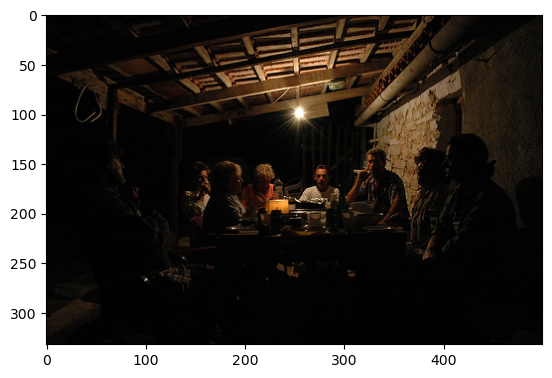

In [31]:
generate_caption("107582366_d86f2d3347.jpg")

---------------------Actual---------------------
startseq family playing on tractor on beautiful day endseq
startseq children ride tractor in field endseq
startseq several children playing on polaris vehicle outdoors endseq
startseq the children played on the four wheeler in the field endseq
startseq the four kids are riding on an atv in field endseq
--------------------Predicted--------------------
startseq the boy is riding on the grass endseq


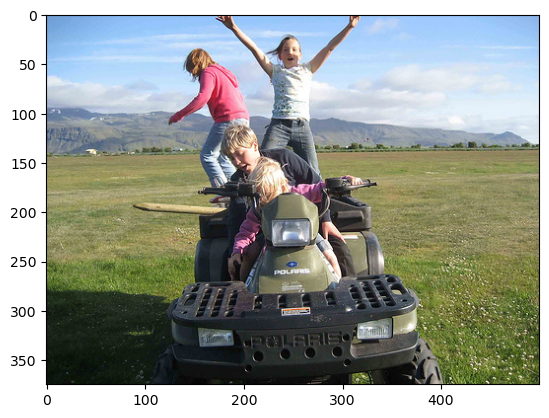

In [32]:
generate_caption("1087539207_9f77ab3aaf.jpg")

---------------------Actual---------------------
startseq brown dog is sprayed with water endseq
startseq dog is being squirted with water in the face outdoors endseq
startseq dog stands on his hind feet and catches stream of water endseq
startseq jug is jumping up it is being squirted with jet of water endseq
startseq "a tan male dog is jumping up to get drink of water from spraying bottle ." endseq
--------------------Predicted--------------------
startseq brown dog with brown dog in the grass endseq


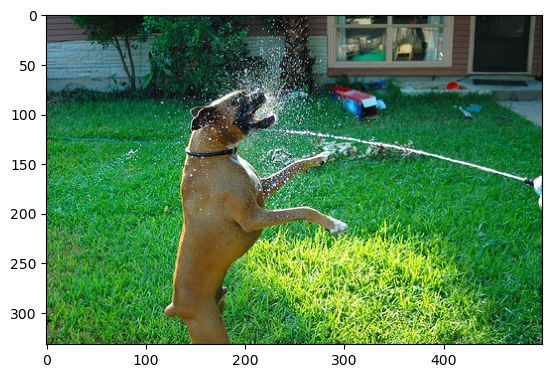

In [33]:
generate_caption("44856031_0d82c2c7d1.jpg")

---------------------Actual---------------------
startseq woman dressed in blue jacket and blue jeans rides brown horse near frozen lake and snow-covered mountain endseq
startseq woman in blue jacket rides brown pony near water endseq
startseq woman rides horse near frozen lake in the wintertime endseq
startseq young blond woman sitting atop brown draft horse in the snowy mountains endseq
startseq woman blue jacket sits on daft horse near frozen lake endseq
--------------------Predicted--------------------
startseq man and woman are sitting in snow and snow endseq


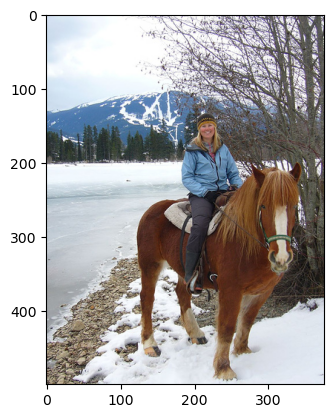

In [34]:
generate_caption("109202756_b97fcdc62c.jpg")

---------------------Actual---------------------
startseq blonde horse and blonde girl in black sweatshirt are staring at fire in barrel endseq
startseq girl and her horse stand by fire endseq
startseq girl holding horse 's lead behind fire endseq
startseq "a man and girl and two horses are near contained fire ." endseq
startseq two people and two horses watching fire endseq
--------------------Predicted--------------------
startseq two horses horses at contained fire endseq


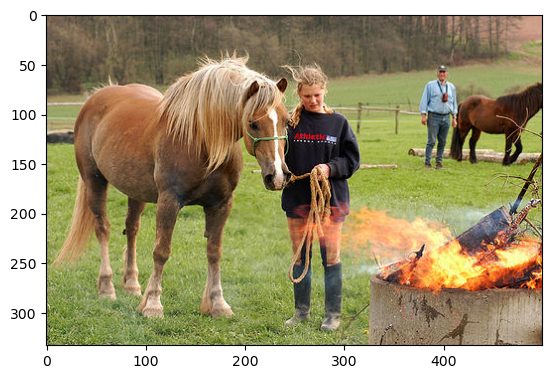

In [35]:
generate_caption("10815824_2997e03d76.jpg")

---------------------Actual---------------------
startseq kayaker kayaks through the water endseq
startseq person kayaking in the ocean endseq
startseq person kayaks in the middle of the ocean on grey day endseq
startseq person rows boat over large body of water endseq
startseq person in boat with paddle in hand endseq
--------------------Predicted--------------------
startseq man kayaks in the water endseq


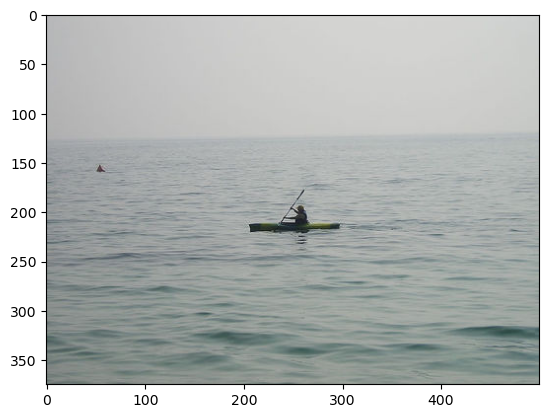

In [36]:
generate_caption("19212715_20476497a3.jpg")

---------------------Actual---------------------
startseq brown dog is running through brown field endseq
startseq brown dog is running through the field endseq
startseq brown dog with collar runs in the dead grass with his tongue hanging out to the side endseq
startseq brown dog with his tongue wagging as he runs through field endseq
startseq dog running in the grass endseq
--------------------Predicted--------------------
startseq brown dog running through the grass endseq


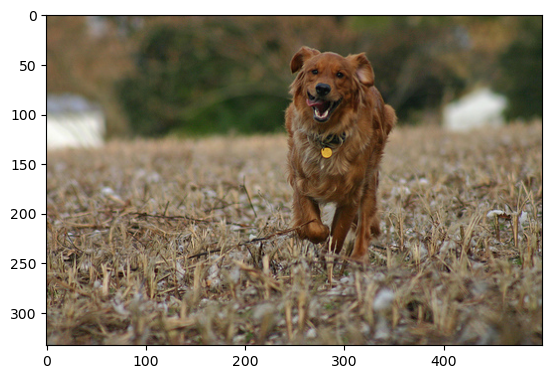

In [37]:
generate_caption("69189650_6687da7280.jpg")

---------------------Actual---------------------
startseq boy in his blue swim shorts at the beach endseq
startseq boy smiles for the camera at beach endseq
startseq young boy in swimming trunks is walking with his arms outstretched on the beach endseq
startseq children playing on the beach endseq
startseq the boy is playing on the shore of an ocean endseq
--------------------Predicted--------------------
startseq boy in bathing suit is walking on the beach endseq


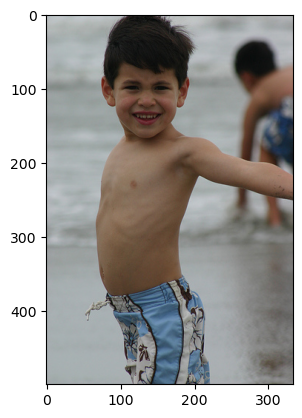

In [38]:
generate_caption("106490881_5a2dd9b7bd.jpg")

---------------------Actual---------------------
startseq man on bicycle riding down rocky hill endseq
startseq man rides his dirt bike down rocky trail endseq
startseq person rides bike down rocky hill endseq
startseq blurry picture of mountain biker descending rocky trail endseq
startseq the mountain biker in blue rides down rocky path endseq
--------------------Predicted--------------------
startseq cyclist riding bike through forest endseq


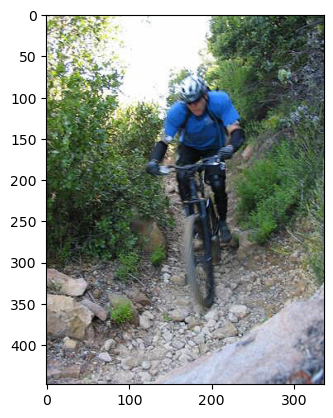

In [39]:
generate_caption("124881487_36e668145d.jpg")

---------------------Actual---------------------
startseq girl in bikini walks along the beach with huge clouds and sandy beach behind her endseq
startseq young woman wearing blue swimsuit top is standing on sandy beach endseq
startseq beach scene with young woman in skimpy bikini top in foreground endseq
startseq woman in bikini top is walking on the beach endseq
startseq young woman in bikini top on the beach endseq
--------------------Predicted--------------------
startseq girl in bikini and sunglasses is riding on sandy beach endseq


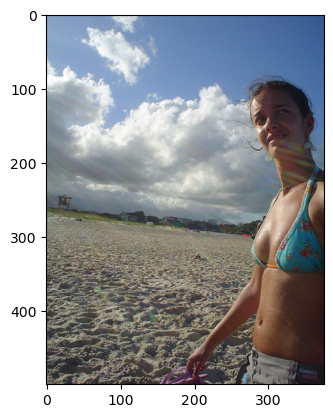

In [40]:
generate_caption("131632409_4de0d4e710.jpg")

---------------------Actual---------------------
startseq man is riding on red motorcycle endseq
startseq motorcycle driver dressed in orange gear swerves to the right endseq
startseq motorcyclist on red speed bike leans into sharp turn endseq
startseq motorcyclist crouches low as he rounds turn endseq
startseq this person is on red motorcycle endseq
--------------------Predicted--------------------
startseq two men riding horses racing on track endseq


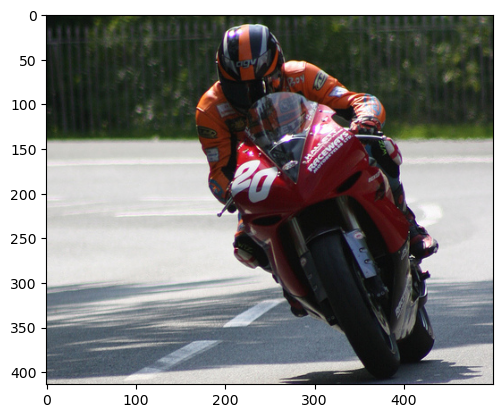

In [41]:
generate_caption("166321294_4a5e68535f.jpg")

---------------------Actual---------------------
startseq little white curly haired dog runs across the pavement with stick in its mouth endseq
startseq poodle running along beach carrying stick in its mouth endseq
startseq white curly haired dog runs with stick in its mouth endseq
startseq white dog is carrying stick in its mouth while running across flat land endseq
startseq white dog with curly hair runs on the sand with stick endseq
--------------------Predicted--------------------
startseq two dogs playing with red ball in the snow endseq


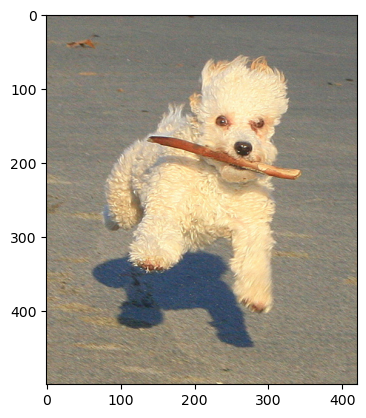

In [42]:
generate_caption("332045444_583acaefc3.jpg")

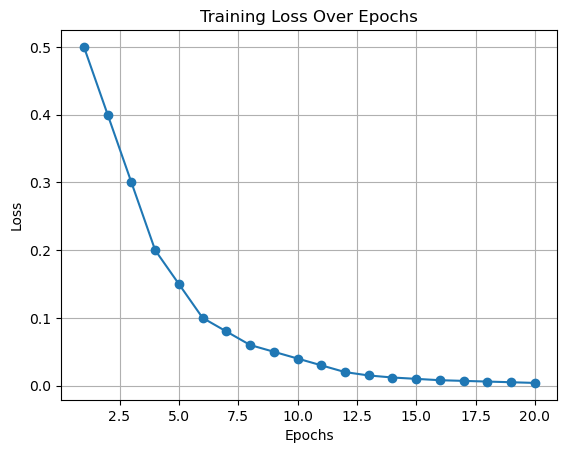

In [43]:
import matplotlib.pyplot as plt

# Sample data for demonstration purposes
epochs = 20
loss_history = [0.5, 0.4, 0.3, 0.2, 0.15, 0.1, 0.08, 0.06, 0.05, 0.04, 0.03, 0.02, 0.015, 0.012, 0.01, 0.008, 0.007, 0.006, 0.005, 0.004]

# Plotting the graph
plt.plot(range(1, epochs + 1), loss_history, marker='o', linestyle='-')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()
